<a href="https://colab.research.google.com/github/michaelguan1992/spinningup-in-deeprl-tensorflow2/blob/master/algos/ppo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow==2.0.0-alpha0
!pip install -q tfp-nightly

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import gym
from gym.spaces import Box, Discrete
import time

import scipy.signal

tfd = tfp.distributions

%matplotlib inline

In [0]:
"""
functions in core.py
"""
EPS = 1e-8


def combined_shape(length, shape=None):
  if shape is None:
    return (length,)
  return (length, shape) if np.isscalar(shape) else (length, *shape)


def discount_cumsum(x, discount):
  """
  magic from rllab for computing discounted cumulative sums of vectors.
  input:
    vector x,
    [x0,
     x1,
     x2]
  output:
    [x0 + discount * x1 + discount^2 * x2,
     x1 + discount * x2,
     x2]
  """
  return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


def gaussian_likelihood(x, mu, log_std):
  pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + EPS))**2 + 2 * log_std + np.log(2 * np.pi))
  return tf.reduce_sum(pre_sum, axis=1)
  
class MLP(tf.keras.Model):
  def __init__(self, 
               sizes, 
               activation='tanh', 
               output_activation=None,
               is_continue_action=False,
               act_dim=None):
    super().__init__()

    self.denses = [tf.keras.layers.Dense(size, activation=activation) for size in sizes[:-1]]
    self.out = tf.keras.layers.Dense(sizes[-1], activation=output_activation)
    if is_continue_action:
      if act_dim is None:
        raise TypeError("__init__() missing 1 argument: 'act_dim' when log_std=True")
      self.log_std = tf.Variable(name='log_std', initial_value=-0.5 * np.ones(act_dim, dtype=np.float32))
    
  @tf.function
  def call(self, x):
    for dense in self.denses:
      x = dense(x)      
    return self.out(x)

def statistics_scalar(x):
  x = np.array(x, dtype=np.float32)
  return np.mean(x), np.std(x)

In [0]:
"""
Actor-Critics
"""

class ActorCritic:
  def __init__(self, hidden_sizes=(64, 64), activation='tanh',
               output_activation=None, action_space=None, pi_lr=3e-4, vf_lr=1e-3,
               train_v_iters=80, train_pi_iters=80):
    if isinstance(action_space, Box):
      act_dim = len(action_space.sample())
      self.pi_mlp = MLP(list(hidden_sizes) + [act_dim], activation, output_activation, is_continue_action=True, act_dim=act_dim)
      self.policy = self._mlp_gaussian_policy

    elif isinstance(action_space, Discrete):
      act_dim = action_space.n
      self.pi_mlp = MLP(list(hidden_sizes) + [act_dim], activation, None)
      self.policy = self._mlp_categorical_policy      
      self.action_space = action_space
      
    # build mlp model
    self.v_mlp = MLP(list(hidden_sizes) + [1], activation, None)
    
    # optimizers
    self.pi_optimizer = tf.optimizers.Adam(learning_rate=pi_lr)
    self.vf_optimizer = tf.optimizers.Adam(learning_rate=vf_lr)
    self.train_v_iters = train_v_iters
    self.train_pi_iters = train_pi_iters

  @tf.function
  def __call__(self, observation, action):
    pi, logp_pi = self.policy(observation, action)
    v = tf.squeeze(self.v_mlp(observation), axis=1)
    return pi, logp_pi, v

  def _mlp_categorical_policy(self, observation, action):
    act_dim = self.action_space.n
    logits = self.pi_mlp(observation)
    logp_all = tf.nn.log_softmax(logits)
    pi = tfd.Categorical(logits).sample()  # pi is the next action
    if action is not None:
      action = tf.cast(action, tf.int32)
      logp = tf.reduce_sum(tf.one_hot(action, act_dim) * logp_all, axis=1)
    else:
      logp = tf.reduce_sum(tf.one_hot(pi, act_dim) * logp_all, axis=1)
    return pi, logp

  def _mlp_gaussian_policy(self, observation, action):
    mu = self.pi_mlp(observation)
    std = tf.exp(self.pi_mlp.log_std)
    pi = mu + tf.random.normal(tf.shape(mu)) * std  # pi is the next action
    if action is not None: 
      logp = gaussian_likelihood(action, mu, self.pi_mlp.log_std)
    else:
      logp = gaussian_likelihood(pi, mu, self.pi_mlp.log_std)
    return pi, logp

  def update(self, buf, clip_ratio, target_kl):
    obs_buf, act_buf, adv_buf, ret_buf, logp_buf = buf.get()

    for i in range(self.train_pi_iters):
      with tf.GradientTape() as pi_tape:
        pi, logp, v = self(obs_buf, act_buf)
        # PPO objectives
        ratio = tf.exp(logp - logp_buf)
        min_adv = tf.where(adv_buf>0, (1+clip_ratio)*adv_buf, (1-clip_ratio)*adv_buf)
        # loss
        pi_loss = -tf.reduce_mean(tf.minimum(ratio * adv_buf, min_adv))
        
      # Info (useful to watch during learning)
      kl = tf.reduce_mean(logp_buf - logp) # a sample estimate for KL-divergence
      if kl > 1.5 * target_kl:
        print('Early stopping at step %d due to reaching max kl.' % i)
        break

      pi_grads = pi_tape.gradient(pi_loss, self.pi_mlp.trainable_variables)
      self.pi_optimizer.apply_gradients(zip(pi_grads, self.pi_mlp.trainable_variables))

    for _ in range(self.train_v_iters):
      with tf.GradientTape() as vf_tape:
        pi, logp, v = self(obs_buf, act_buf)
        v_loss = tf.reduce_mean((ret_buf - v) ** 2)
      vf_grads = vf_tape.gradient(v_loss, self.v_mlp.trainable_variables)

In [0]:
class VPGBuffer:
  """
  A buffer for storing trajectories experienced by a VPG agent interacting
  with the environment, and using Generalized Advantage Estimation (GAE-Lambda)
  for calculating the advantages of state-action pairs.
  """

  def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
    self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
    self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
    self.adv_buf = np.zeros(size, dtype=np.float32)
    self.rew_buf = np.zeros(size, dtype=np.float32)
    self.ret_buf = np.zeros(size, dtype=np.float32)
    self.val_buf = np.zeros(size, dtype=np.float32)
    self.logp_buf = np.zeros(size, dtype=np.float32)
    self.gamma, self.lam = gamma, lam
    self.ptr, self.path_start_idx, self.max_size = 0, 0, size

  def store(self, obs, act, rew, val, logp):
    """
    Append one timestep of agent-environment interaction to the buffer.
    """
    assert self.ptr < self.max_size     # buffer has to have room so you can store
    self.obs_buf[self.ptr] = obs
    self.act_buf[self.ptr] = act
    self.rew_buf[self.ptr] = rew
    self.val_buf[self.ptr] = val
    self.logp_buf[self.ptr] = logp
    self.ptr += 1

  def finish_path(self, last_val=0):
    """
    Call this at the end of a trajectory, or when one gets cut off
    by an epoch ending. This looks back in the buffer to where the
    trajectory started, and uses rewards and value estimates from
    the whole trajectory to compute advantage estimates with GAE-Lambda,
    as well as compute the rewards-to-go for each state, to use as
    the targets for the value function.
    The "last_val" argument should be 0 if the trajectory ended
    because the agent reached a terminal state (died), and otherwise
    should be V(s_T), the value function estimated for the last state.
    This allows us to bootstrap the reward-to-go calculation to account
    for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
    """

    path_slice = slice(self.path_start_idx, self.ptr)
    rews = np.append(self.rew_buf[path_slice], last_val)
    vals = np.append(self.val_buf[path_slice], last_val)

    # the next two lines implement GAE-Lambda advantage calculation
    deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
    self.adv_buf[path_slice] = discount_cumsum(deltas, self.gamma * self.lam)

    # the next line computes rewards-to-go, to be targets for the value function
    self.ret_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1]

    self.path_start_idx = self.ptr

  def get(self):
    """
    Call this at the end of an epoch to get all of the data from
    the buffer, with advantages appropriately normalized (shifted to have
    mean zero and std one). Also, resets some pointers in the buffer.
    """
    assert self.ptr == self.max_size    # buffer has to be full before you can get
    self.ptr, self.path_start_idx = 0, 0
    # the next two lines implement the advantage normalization trick
    adv_mean, adv_std = statistics_scalar(self.adv_buf)
    self.adv_buf = (self.adv_buf - adv_mean) / adv_std
    return self.obs_buf, self.act_buf, self.adv_buf, self.ret_buf, self.logp_buf

In [0]:
"""
Vanilla Policy Gradient
(with GAE-Lambda for advantage estimation)
"""


def vpg(env, ac_kwargs=None, seed=0, steps_per_epoch=4000, epochs=50, gamma=0.99,
        clip_ratio=0.2, pi_lr=3e-4, vf_lr=1e-3, train_pi_iters=80, 
        train_v_iters=80, lam=0.97, max_ep_len=1000, target_kl=0.01, save_freq=10):

  tf.random.set_seed(seed)
  np.random.seed(seed)
  # Create actor-critic agent 
  ac_kwargs['action_space'] = env.action_space
  ac_kwargs['pi_lr'] = pi_lr
  ac_kwargs['vf_lr'] = vf_lr
  ac_kwargs['train_pi_iters'] = train_pi_iters
  ac_kwargs['train_v_iters'] = train_v_iters
  actor_critic = ActorCritic(**ac_kwargs)

  # Experience buffer
  obs_dim = env.observation_space.shape
  act_dim = env.action_space.shape
  buf = VPGBuffer(obs_dim, act_dim, steps_per_epoch, gamma, lam)

  """
  Main loop: collect experience in env and update/log each epoch
  """

  # o for observation, r for reward, d for done
  o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0

  all_ep_ret = []
  summary_ep_ret = []
  totalEnvInteracts = []
  for epoch in range(epochs):
    for t in range(steps_per_epoch):

      a, logp_t, v_t = actor_critic(o.reshape(1, -1).astype(np.float32), None)

      # save and log
      a = a.numpy()[0]
      buf.store(o, a, r, v_t, logp_t)

      o, r, d, _ = env.step(a)
      ep_ret += r
      ep_len += 1

      terminal = d or (ep_len == max_ep_len)
      if terminal or (t == steps_per_epoch - 1):
        if not(terminal):
          print('Warning: trajectory cut off by epoch at %d steps.' % ep_len)
        # if trajectory didn't reach terminal state, bootstrap value target
        last_val = r if d else v_t
        buf.finish_path(last_val)

        if terminal:
          all_ep_ret.append(ep_ret)
        # reset environment
        o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0

    # Perform VPG update!
    actor_critic.update(buf, clip_ratio, target_kl)
    mean, std = statistics_scalar(all_ep_ret)
    all_ep_ret = []

    print(f'epoch {epoch}: mean {mean}, std {std}')
    summary_ep_ret.append(mean)
    totalEnvInteracts.append((epoch + 1) * steps_per_epoch)

  plt.plot(totalEnvInteracts, summary_ep_ret)
  plt.grid(True)
  plt.show()


Early stopping at step 6 due to reaching max kl.
epoch 0: mean 16.822784423828125, std 8.292276382446289
Early stopping at step 7 due to reaching max kl.
epoch 1: mean 19.75742530822754, std 10.380654335021973
Early stopping at step 11 due to reaching max kl.
epoch 2: mean 24.672840118408203, std 12.868677139282227
epoch 3: mean 34.50434875488281, std 20.503816604614258
epoch 4: mean 52.6533317565918, std 39.77385711669922
epoch 5: mean 77.23529052734375, std 55.095848083496094
epoch 6: mean 98.92500305175781, std 52.56728744506836
epoch 7: mean 148.3076934814453, std 53.5750846862793
epoch 8: mean 147.59259033203125, std 50.572471618652344
epoch 9: mean 166.4583282470703, std 44.11063766479492
epoch 10: mean 179.36363220214844, std 40.88514709472656
epoch 11: mean 168.47825622558594, std 30.841629028320312
epoch 12: mean 187.7142791748047, std 34.06037139892578
epoch 13: mean 195.10000610351562, std 15.546381950378418
epoch 14: mean 196.89999389648438, std 13.512587547302246
epoch 15:

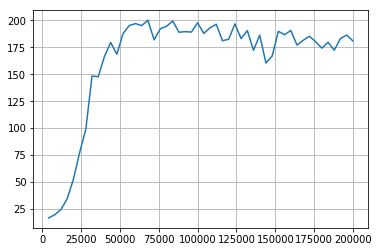

In [43]:
vpg(gym.make('CartPole-v0'), ac_kwargs=dict(hidden_sizes=[64] * 2), gamma=0.99, seed=0, steps_per_epoch=4000, epochs=20)